In [17]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
raw_features = 589

In [19]:
# === Step 1: Load data ===
df = pd.read_excel('3. Dataset_UTS.xlsx')
# Load test data
DT = pd.read_excel('3. Datatest_UTS.xlsx')

# Normalization

In [20]:
# Simplest
'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, -110)
df'''

# Linear Normalization to [0,1] Using Dataset Minimum

'''rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute minimum RSSI value (exclude 0s from consideration)
# Only consider values < 0 (i.e., actual signal readings), ignore 0 (no signal)
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 4: Apply linear normalization
# Keep 0s as 0 (representing no signal), and normalize only values < 0
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: 0 if x >= 0 else (x - rssi_min) / -rssi_min
)
df'''

# Powered Normalization Using Dataset Minimum

'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first raw_features columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute dataset-wide minimum RSSI (only for real signal values, excluding 0) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 4: Apply powered normalization (exclude 0 from normalization) ===
gamma = 2  # you can change this exponent as needed

df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: ((x - rssi_min) / -rssi_min) ** gamma if x < 0 else 0
)

df'''

# Min-Max Normalization Using Global Min/Max

'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Compute dataset-wide min and max RSSI values (excluding 0s) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
rssi_max = df[rssi_columns][df[rssi_columns] < 0].max().max()

# === Step 4: Apply Min-Max Normalization to [0, 1] (exclude 0 from normalization) ===
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: (x - rssi_min) / (rssi_max - rssi_min) if x < 0 else 0
)

df'''

# Powered Transformation After Per-Fingerprint Normalization

'''# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Convert RSSI to positive by shifting (only for non-zero values)
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
shift = rssi_min - 1

# Shift only values less than 0, leave 0s unchanged
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 4: Per-row (fingerprint) normalization (excluding 0s) ===
# Normalize each row based on the max of non-zero entries
row_max = df[rssi_columns].replace(0, pd.NA).max(axis=1)

df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 5: Apply powered transformation (e.g., square) only to non-zero values
gamma = 2  # You can set this to any exponent like e, 1.5, etc.
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x**gamma if x > 0 else 0)

df'''

# Sigmoid-Scaled Row Normalization

# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]  # assuming RSSI is in the first raw_features columns

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Shift RSSI to positive (only non-zero) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
shift = rssi_min - 1  # shift negative RSSI to positive
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 4: Row-wise normalization (exclude zeros) ===
row_max = df[rssi_columns].replace(0, pd.NA).max(axis=1)
df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 5: Apply sigmoid transformation to non-zero values ===
alpha = 10  # steepness of sigmoid
beta = 0.5  # midpoint
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_20072\3564184693.py:104: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_20072\3564184693.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_20072\3564184693.py:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(


In [21]:
'''# === Step 1: Select RSSI columns ===
rssi_columns = DT.columns[:raw_features]  # assuming RSSI is in the first `raw_features` columns

# === Step 2: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, -110)
DT'''

# Linear Normalization to [0,1] Using Dataset Minimum

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse the dataset-wide minimum RSSI value from training ===
# Ensure `rssi_min` is defined from the training set beforehand
# rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()

# === Step 3: Apply the linear normalization formula (excluding 0s) ===
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: 0 if x >= 0 else (x - rssi_min) / -rssi_min
)
DT'''

# Powered Normalization Using Dataset Minimum

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse the dataset-wide minimum RSSI value from training ===
# Make sure `rssi_min` is defined and matches the one used during training:
# Example:
# rssi_min = -104

# === Step 3: Apply powered normalization (exclude 0 from normalization) ===
gamma = 2  # Power factor (can also use math.e or another value)

DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: ((x - rssi_min) / -rssi_min) ** gamma if x < 0 else 0
)

DT'''

# Min-Max Normalization Using Global Min/Max

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse dataset-wide min and max RSSI values from training ===
# Ensure rssi_min and rssi_max were saved during training:
# Example:
# rssi_min = -104
# rssi_max = -30

# === Step 3: Apply Min-Max Normalization to [0, 1] (exclude 0 from normalization) ===
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: (x - rssi_min) / (rssi_max - rssi_min) if x < 0 else 0
)

DT'''

# Powered Transformation After Per-Fingerprint Normalization

'''# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Reuse dataset-wide minimum RSSI value from training to shift into positive range
# Make sure `rssi_min` is defined (e.g., rssi_min = -104)
shift = rssi_min - 1

# Shift only real RSSI values (< 0), leave 0s untouched
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 3: Normalize each fingerprint row-wise to [0, 1], excluding 0s ===
row_max = DT[rssi_columns].replace(0, pd.NA).max(axis=1)
DT[rssi_columns] = DT[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 4: Apply powered transformation only to non-zero values ===
#gamma = 2  # You can adjust this exponent as needed
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x**gamma if x > 0 else 0)

DT'''


# Sigmoid-Scaled Row Normalization


# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Shift RSSI using dataset-wide min (from training) ===

shift = rssi_min - 1  # shift negative RSSI to positive
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 3: Row-wise normalization (exclude zeros) ===
row_max = DT[rssi_columns].replace(0, np.nan).max(axis=1)
DT[rssi_columns] = DT[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 4: Apply sigmoid transformation ===
alpha = 10  # steepness of the sigmoid
beta = 0.5 # midpoint
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_20072\1906004430.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_20072\1906004430.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(


In [22]:
X = df.iloc[:,:raw_features]
X_target = DT.iloc[:,:raw_features]

y_floor = df.iloc[:, -3]
y_coordinate = df.iloc[:, [-5,-4]]
y_target_floor = DT.iloc[:,-2]
y_target_coordinate = DT.iloc[:, [-4,-3]]

In [23]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit on training labels and transform both sets
y_floor_encoded = label_encoder.fit_transform(y_floor)
y_target_floor_encoded = label_encoder.transform(y_target_floor)

# Ensure y_floor_encoded is a pandas Series with same index as X
y_floor_series = pd.Series(y_floor_encoded, index=X.index)

# Important Features

In [24]:
# Confidence weighting using Pearson correlation

# Now compute correlations
correlations = X.apply(lambda x: x.corr(y_floor_series), axis=0)

# Step 6.2: Replace NaN with 0
correlations = correlations.fillna(0)

# Step 6.3: Compute confidence weights
# You can replace this with SHAP / MI / permutation importance if available
confidence_weights = correlations.abs()

# Optional: scale weights to [0, 1]
confidence_weights = confidence_weights / confidence_weights.max()

# Step 6.4: Multiply each feature by its confidence weight
X_weighted = X.mul(confidence_weights, axis=1)

C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [25]:
# Confidence weighting using Pearson correlation

# Step 6.5: Remove all-zero columns
X_weighted_cleaned = X_weighted.loc[:, (X_weighted != 0).any(axis=0)]

# Step 6.6: Update feature count
raw_features = X_weighted_cleaned.shape[1]

# Result: X_weighted_cleaned has transformed, normalized, and confidence-weighted features
X_weighted_cleaned

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP580,WAP581,WAP582,WAP583,WAP584,WAP585,WAP586,WAP587,WAP588,WAP589
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9103,0.0,0.0,0.0,0.0,0.325121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681034,0.774469,0.727328
9104,0.0,0.0,0.0,0.0,0.325121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681034,0.774469,0.727328
9105,0.0,0.0,0.0,0.0,0.325121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681034,0.774469,0.727328
9106,0.0,0.0,0.0,0.0,0.325121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681034,0.774469,0.727328


In [26]:
# Confidence weighting using Pearson correlation

# Step 2: Apply the same weights to X_target
X_target_weighted = X_target.mul(confidence_weights, axis=1)

# Step 3: Keep only the columns that were kept in training
X_target_weighted_cleaned = X_target_weighted[X_weighted_cleaned.columns]

X_target_weighted_cleaned

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP580,WAP581,WAP582,WAP583,WAP584,WAP585,WAP586,WAP587,WAP588,WAP589
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.040505,0.022717,0.0,0.0,0.0,0.0,0.0,0.0
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X = X_weighted_cleaned
X_target = X_target_weighted_cleaned

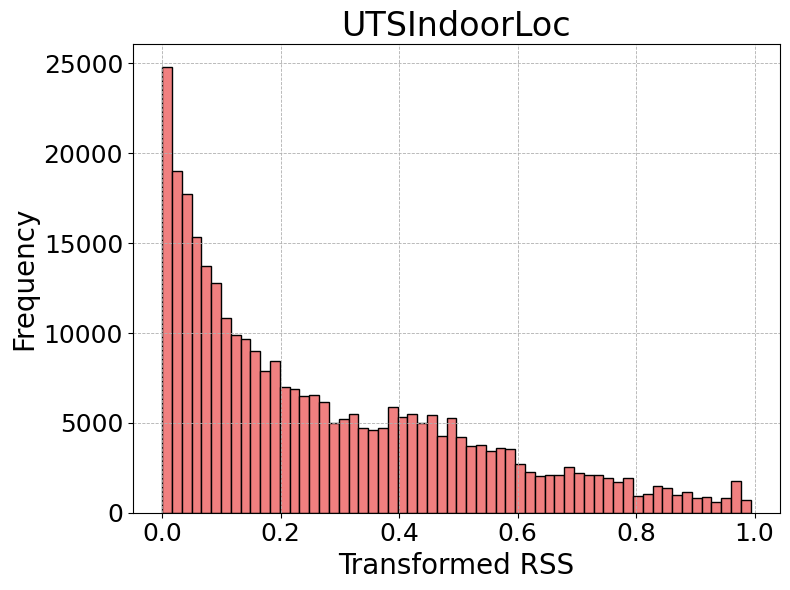

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
#df = pd.read_excel('3. Dataset_UTS.xlsx')
#X = df.iloc[:, :raw_features]

# Flatten all values into a single array
all_values = X.values.flatten()

# Remove NaNs and values equal to 100
all_values = all_values[~pd.isnull(all_values)]
all_values = all_values[all_values != 0]  # <-- Exclude 100

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
ax.hist(all_values, bins=60, color='lightcoral', edgecolor='black', zorder=1)

# Grid behind
ax.grid(True, linestyle='--', linewidth=0.6, zorder=1)

# Titles and labels
ax.set_title("UTSIndoorLoc", fontsize=24)
ax.set_xlabel("Transformed RSS", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)

# ✅ Adjust tick font sizes
ax.tick_params(axis='both', labelsize=18)
plt.tight_layout()
plt.savefig('Transformed UTSIndoorLoc distribution.svg', dpi = 600)
plt.show()

# Floor Prediction

In [29]:
import optuna
import random
import numpy as np
from optuna.exceptions import TrialPruned
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [30]:
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_floor_series, test_size=0.2, random_state=42)

# --- Fix random seeds for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [31]:
import time
import numpy as np
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

start_time1 = time.time()

# --- Custom weight function for KNN ---
def knn_weight(d):
    return 1 / (d + 1e-6) ** 2


# --- Objective function for KNN ---
def objective_wknn(trial):
    knn = KNeighborsClassifier(
        n_neighbors=trial.suggest_int('n_neighbors', 1, 50),
        p=trial.suggest_int('p', 1, 5),
        metric=trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']),
        weights=knn_weight
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for RandomForest ---
def objective_rf(trial):
    rf = RandomForestClassifier(
        max_depth=trial.suggest_categorical('max_depth', [None] + list(range(5, 51))),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for LightGBM ---
def objective_lgb(trial):
    model = lgb.LGBMClassifier(
        n_estimators=10000,
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        num_leaves=trial.suggest_int('num_leaves', 20, 100),
        max_depth=trial.suggest_int('max_depth', 3, 30),
        min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=SEED,
        verbosity=-1,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_error',
            callbacks=[lgb.early_stopping(100)]
        )

        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for XGBoost ---
def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_float('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 0, 5),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        eval_metric='mlogloss',
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for GaussianNB ---
def objective_gnb(trial):
    model = GaussianNB(
        var_smoothing=trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)


# --- Objective function for AdaBoost ---
def objective_adaboost(trial):
    base_estimator = DecisionTreeClassifier(
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        max_depth=trial.suggest_int('max_depth', 1, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        random_state=SEED
    )

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        random_state=SEED
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)

In [32]:
# KNN
# --- Run the optimization ---
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_wknn, n_trials=100, timeout=300)

# --- Get best parameters ---
best_params1 = study1.best_params
print("Best KNN hyperparameters:", best_params1)

# --- Train final model ---
knn_floor_final = KNeighborsClassifier(
    n_neighbors=best_params1['n_neighbors'],
    weights=knn_weight,
    p=best_params1['p'],
    metric=best_params1['metric']
)

# --- Cross-validation accuracy ---
cv_scores_knn = cross_val_score(knn_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("KNN Cross-val Accuracies:", cv_scores_knn)
print("KNN Mean CV Accuracy:", cv_scores_knn.mean())

# --- Train on full training set ---
knn_floor_final.fit(X_train, y_train)
joblib.dump(knn_floor_final, 'knn_floor_UTS.joblib')

[I 2025-12-20 15:16:22,968] A new study created in memory with name: no-name-1e19ac5f-6618-4c04-904d-e7f74376bb4a
[I 2025-12-20 15:16:32,164] Trial 0 finished with value: 0.9965691383444758 and parameters: {'n_neighbors': 5, 'p': 4, 'metric': 'manhattan'}. Best is trial 0 with value: 0.9965691383444758.
[I 2025-12-20 15:16:37,047] Trial 1 finished with value: 0.9906675403637706 and parameters: {'n_neighbors': 26, 'p': 2, 'metric': 'euclidean'}. Best is trial 0 with value: 0.9965691383444758.
[I 2025-12-20 15:16:46,480] Trial 2 finished with value: 0.9962945074767948 and parameters: {'n_neighbors': 8, 'p': 4, 'metric': 'manhattan'}. Best is trial 0 with value: 0.9965691383444758.
[I 2025-12-20 15:17:49,555] Trial 3 finished with value: 0.9884712466094809 and parameters: {'n_neighbors': 5, 'p': 5, 'metric': 'minkowski'}. Best is trial 0 with value: 0.9965691383444758.
[I 2025-12-20 15:17:58,676] Trial 4 finished with value: 0.9947847438175103 and parameters: {'n_neighbors': 22, 'p': 1, '

Best KNN hyperparameters: {'n_neighbors': 1, 'p': 4, 'metric': 'manhattan'}
KNN Cross-val Accuracies: [0.99862826 1.         0.99862826 1.         0.99588477 0.99725652
 0.99862637 0.99862637 1.         0.99725275]
KNN Mean CV Accuracy: 0.9984903299718116


['knn_floor_UTS.joblib']

In [33]:
# Random Forest
# --- Run the optimization ---
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_rf, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params2 = study2.best_params
print("Best Random Forest hyperparameters:", best_params2)

rf_floor_final = RandomForestClassifier(
    **best_params2,
    random_state=SEED,
    n_jobs=-1
)

# --- Cross-validation accuracy ---
cv_scores_rf = cross_val_score(rf_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("RF Cross-val Accuracies:", cv_scores_rf)
print("RF Mean CV Accuracy:", cv_scores_rf.mean())

# --- Train on full training set ---
rf_floor_final.fit(X_train, y_train)
joblib.dump(rf_floor_final, 'rf_floor_pred_UTS.joblib')

[I 2025-12-20 15:21:48,825] A new study created in memory with name: no-name-b50f4cc4-68a0-46ca-8ae1-f816469d375b
[I 2025-12-20 15:22:03,221] Trial 0 finished with value: 0.992040506405386 and parameters: {'max_depth': 28, 'n_estimators': 359, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.992040506405386.
[I 2025-12-20 15:22:16,573] Trial 1 finished with value: 0.7705189365373915 and parameters: {'max_depth': 5, 'n_estimators': 243, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.992040506405386.
[I 2025-12-20 15:22:26,205] Trial 2 finished with value: 0.9938243360419827 and parameters: {'max_depth': 18, 'n_estimators': 107, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.9938243360419827.
[I 2025-12-20 15:23:49,071] Trial 3 finished with value: 0.9803737314680653 and parameters: {'max_depth': 30, 'n_estimators': 339, 'mi

Best Random Forest hyperparameters: {'max_depth': 18, 'n_estimators': 107, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}
RF Cross-val Accuracies: [1.         0.99314129 1.         0.99176955 0.99176955 0.99314129
 0.99587912 0.99175824 0.99862637 0.99587912]
RF Mean CV Accuracy: 0.9951964530668235


['rf_floor_pred_UTS.joblib']

In [34]:
# Run Optuna study
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_lgb, n_trials=100, timeout=300)

# Best params
best_params3 = study3.best_params
print("Best LightGBM hyperparameters:", best_params3)

best_params3.update({
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train))
})

# Final model
lgb_floor_final = lgb.LGBMClassifier(**best_params3)

# Cross-validation
cv_scores_lgb = cross_val_score(lgb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("LGB Cross-val Accuracies:", cv_scores_lgb)
print("LGB Mean CV Accuracy:", cv_scores_lgb.mean())

# Train final model
lgb_floor_final.fit(X_train, y_train)

# Save
joblib.dump(lgb_floor_final, 'lgb_floor_pred_UTS.joblib')

[I 2025-12-20 15:27:18,728] A new study created in memory with name: no-name-4190ba18-0b18-4843-8cd7-077788bb7f48


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_error: 0.000685871	valid_0's multi_logloss: 0.00664267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_error: 0.000686342	valid_0's multi_logloss: 0.00878383
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's multi_error: 0.000686342	valid_0's multi_logloss: 0.00245642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's multi_error: 0.00274537	valid_0's multi_logloss: 0.00581658
Training until validation scores don't improve for 100 rounds


[I 2025-12-20 15:56:30,771] Trial 0 finished with value: 0.998764678911607 and parameters: {'learning_rate': 0.06073158710801616, 'num_leaves': 83, 'max_depth': 13, 'min_child_samples': 82}. Best is trial 0 with value: 0.998764678911607.


Early stopping, best iteration is:
[59]	valid_0's multi_error: 0.00137268	valid_0's multi_logloss: 0.015407
Best LightGBM hyperparameters: {'learning_rate': 0.06073158710801616, 'num_leaves': 83, 'max_depth': 13, 'min_child_samples': 82}
LGB Cross-val Accuracies: [0.99862826 0.99862826 1.         1.         1.         0.99862826
 0.99862637 1.         0.99862637 1.        ]
LGB Mean CV Accuracy: 0.99931375209153


['lgb_floor_pred_UTS.joblib']

In [35]:
# XGBoost
# --- Run optimization ---
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective_xgb, n_trials=100, timeout=300)

# --- Best parameters ---
best_params4 = study4.best_params
print("Best XGBoost hyperparameters:", best_params4)

# --- Train final model with best params ---
xgb_floor_final = XGBClassifier(**best_params4, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)

# --- Cross-validation accuracy ---
cv_scores_xgb = cross_val_score(xgb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("XGB Cross-val Accuracies:", cv_scores_xgb)
print("XGB Mean CV Accuracy:", cv_scores_xgb.mean())

# --- Train on full training set ---
xgb_floor_final.fit(X_train, y_train)
joblib.dump(xgb_floor_final, 'xgb_floor_pred_UTS.joblib')

[I 2025-12-20 15:57:34,791] A new study created in memory with name: no-name-97da2c6e-6613-477c-acd9-5e4a19f50372
[I 2025-12-20 15:58:49,896] Trial 0 finished with value: 0.9986275988487534 and parameters: {'n_estimators': 150, 'learning_rate': 0.020356790820459825, 'max_depth': 10, 'min_child_weight': 1.0796362989803954, 'gamma': 1.1827041138524246, 'subsample': 0.7599385810747621, 'colsample_bytree': 0.6630540937234843}. Best is trial 0 with value: 0.9986275988487534.
[I 2025-12-20 15:59:50,055] Trial 1 finished with value: 0.998215887918219 and parameters: {'n_estimators': 114, 'learning_rate': 0.039638184784598914, 'max_depth': 6, 'min_child_weight': 9.305004671877706, 'gamma': 2.747674942769478, 'subsample': 0.8445325778486336, 'colsample_bytree': 0.8841526747660291}. Best is trial 0 with value: 0.9986275988487534.
[I 2025-12-20 16:00:26,474] Trial 2 finished with value: 0.9982160762150085 and parameters: {'n_estimators': 103, 'learning_rate': 0.1343356294543574, 'max_depth': 5, '

Best XGBoost hyperparameters: {'n_estimators': 150, 'learning_rate': 0.020356790820459825, 'max_depth': 10, 'min_child_weight': 1.0796362989803954, 'gamma': 1.1827041138524246, 'subsample': 0.7599385810747621, 'colsample_bytree': 0.6630540937234843}
XGB Cross-val Accuracies: [0.99725652 0.99862826 1.         1.         0.99862826 0.99862826
 0.99725275 1.         0.99725275 1.        ]
XGB Mean CV Accuracy: 0.998764678394308


C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [16:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['xgb_floor_pred_UTS.joblib']

In [37]:
# Gaussian Naive Bayes
# --- Run the optimization ---
study7 = optuna.create_study(direction='maximize')
study7.optimize(objective_gnb, n_trials=50, timeout=200)

# --- Train final model with best hyperparameters ---
best_params7 = study7.best_params
print("Best Naive Bayes hyperparameters:", best_params7)

gnb_floor_final = GaussianNB(**best_params7)

# --- Cross-validation accuracy ---
cv_scores_gnb = cross_val_score(gnb_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("GNB Cross-val Accuracies:", cv_scores_gnb)
print("GNB Mean CV Accuracy:", cv_scores_gnb.mean())

# --- Train on full training set ---
gnb_floor_final.fit(X_train, y_train)
joblib.dump(gnb_floor_final, 'gnb_floor_pred_UTS.joblib')

[I 2025-12-20 16:04:56,385] A new study created in memory with name: no-name-2df27f02-b763-43c3-9f2c-135d88557308
[I 2025-12-20 16:04:58,019] Trial 0 finished with value: 0.948394534497384 and parameters: {'var_smoothing': 2.1740831410217663e-10}. Best is trial 0 with value: 0.948394534497384.
[I 2025-12-20 16:04:59,700] Trial 1 finished with value: 0.9486690712166702 and parameters: {'var_smoothing': 9.382764133288907e-10}. Best is trial 1 with value: 0.9486690712166702.
[I 2025-12-20 16:05:01,363] Trial 2 finished with value: 0.946747784923641 and parameters: {'var_smoothing': 3.743872025091259e-11}. Best is trial 1 with value: 0.9486690712166702.
[I 2025-12-20 16:05:03,064] Trial 3 finished with value: 0.9493550364213064 and parameters: {'var_smoothing': 5.102959173103421e-08}. Best is trial 3 with value: 0.9493550364213064.
[I 2025-12-20 16:05:05,069] Trial 4 finished with value: 0.9452383978579357 and parameters: {'var_smoothing': 1.2557633073710208e-11}. Best is trial 3 with valu

Best Naive Bayes hyperparameters: {'var_smoothing': 3.161810966631307e-08}
GNB Cross-val Accuracies: [0.9478738  0.9478738  0.94513032 0.95610425 0.95473251 0.94650206
 0.93406593 0.9532967  0.93818681 0.95604396]
GNB Mean CV Accuracy: 0.947981014184718


['gnb_floor_pred_UTS.joblib']

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import joblib

# --- Run the optimization ---
study_ab = optuna.create_study(direction='maximize')
study_ab.optimize(objective_adaboost, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params_ab = study_ab.best_params
print("Best hyperparameters:", best_params_ab)

# Extract AdaBoost-specific parameters
ada_params = {
    'n_estimators': best_params_ab.pop('n_estimators'),
    'learning_rate': best_params_ab.pop('learning_rate'),
    'random_state': SEED
}

# Remaining params go to base estimator (DecisionTree)
base_estimator = DecisionTreeClassifier(**best_params_ab, random_state=SEED)

# Build final AdaBoost model
ab_floor_final = AdaBoostClassifier(
    estimator=base_estimator,
    **ada_params
)

# --- Cross-validation accuracy ---
cv_scores_ab = cross_val_score(ab_floor_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("AdaBoost Cross-val Accuracies:", cv_scores_ab)
print("AdaBoost Mean CV Accuracy:", cv_scores_ab.mean())

# --- Train on full training set ---
ab_floor_final.fit(X_train, y_train)
joblib.dump(ab_floor_final, 'adaboost_floor_pred_UTS.joblib')

[I 2025-12-20 16:06:28,831] A new study created in memory with name: no-name-b5a0d95a-94c5-4f56-9faa-2184f04d4bfd
[I 2025-12-20 16:09:31,851] Trial 0 finished with value: 0.9887462540707412 and parameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 17, 'n_estimators': 253, 'learning_rate': 0.1565957542919959}. Best is trial 0 with value: 0.9887462540707412.
[I 2025-12-20 16:15:47,836] Trial 1 finished with value: 0.9984903304891104 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 4, 'n_estimators': 282, 'learning_rate': 0.20954975837372336}. Best is trial 1 with value: 0.9984903304891104.


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 4, 'n_estimators': 282, 'learning_rate': 0.20954975837372336}
AdaBoost Cross-val Accuracies: [1.         0.99862826 1.         1.         0.99862826 0.99725652
 0.99862637 1.         0.99587912 1.        ]
AdaBoost Mean CV Accuracy: 0.9989018526055563


['adaboost_floor_pred_UTS.joblib']

In [39]:
models = [
        ("KNN", knn_floor_final),
        ("RF", rf_floor_final),
        ("LGB", lgb_floor_final),
        ("XGB", xgb_floor_final),
        ("NB", gnb_floor_final),
        ("AB", ab_floor_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgb.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_gnb = cv_scores_gnb.mean()
accuracy_ab = cv_scores_ab.mean()

In [40]:
# IEO-CVV

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

def ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...")

    # --- Step 1: Compute cross-val scores and predictions ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        acc = cv_scores.mean()
        model_scores[name] = acc

        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
        model_preds[name] = y_pred_cv

        print(f"{name} CV Accuracy: {acc:.4f}")

    # Sort models by CV accuracy
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Ensemble voting function (CV-based predictions) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])
        weights = np.array([model_scores[name] for name in selected_model_names])
        weighted_preds = []

        for i in range(preds.shape[1]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)

        return np.array(weighted_preds)

    # --- Step 2: Initialize ensemble with top 2 models ---
    ensemble = sorted_models[:2]  # Changed here: top 2 models
    ensemble_names = [name for name, _ in ensemble]
    best_acc = accuracy_score(y_train, ensemble_predict_cv(ensemble_names))
    print(f"Initial Ensemble: {[n for n, _ in ensemble]} - Train Accuracy: {best_acc:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        new_acc = accuracy_score(y_train, y_pred_temp)

        if new_acc > best_acc:
            ensemble = temp_ensemble
            best_acc = new_acc
            improved = True
            patience_counter = 0
            print(f"Added {name} - Improved Train Accuracy: {new_acc:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, m in ensemble:
                    if n == name:
                        continue
                    temp_ensemble_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_ensemble_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_acc = accuracy_score(y_train, y_pred_pruned)

                    if pruned_acc >= best_acc:
                        print(f"Pruned {n} - Accuracy maintained/improved: {pruned_acc:.4f}")
                        ensemble = temp_ensemble_pruned
                        best_acc = pruned_acc
                        pruned = True
                        break
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {new_acc:.4f} (Patience: {patience_counter}/{patience})")

    # --- Final weights based on normalized CV accuracies ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train Accuracy:", best_acc)

    # --- Step 4: Retrain final models and test ensemble ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([m.predict(X).ravel() for _, m in selected_models])
        weights = np.array([model_scores[name] for name, _ in selected_models])
        weighted_preds = []
        for i in range(X.shape[0]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)
        return np.array(weighted_preds)

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Final Ensemble Test Accuracy:", test_acc)

    return ensemble, best_acc, weights, test_acc

In [41]:
def ensemble_predict(ensemble, X, model_scores):
    preds = np.array([m.predict(X).ravel() for _, m in ensemble])
    weights = np.array([model_scores[name] for name, _ in ensemble])

    weighted_preds = []
    for i in range(X.shape[0]):
        classes, counts = np.unique(preds[:, i], return_counts=True)
        # Weighted voting
        vote_score = {c: 0 for c in classes}
        for j, c in enumerate(preds[:, i]):
            vote_score[c] += weights[j]
        weighted_preds.append(max(vote_score, key=vote_score.get))

    return np.array(weighted_preds)

# IEO-CVV

In [42]:
ensemble2, best_acc2, ensemble_weights2, test_acc2 = ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test)

end_time1 = time.time()

training_time1 = end_time1 - start_time1
print(f"Training time: {training_time1:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...
Evaluating KNN...
KNN CV Accuracy: 0.9985
Evaluating RF...
RF CV Accuracy: 0.9952
Evaluating LGB...
LGB CV Accuracy: 0.9993
Evaluating XGB...
XGB CV Accuracy: 0.9988
Evaluating NB...
NB CV Accuracy: 0.9480
Evaluating AB...
AB CV Accuracy: 0.9989
Initial Ensemble: ['LGB', 'AB'] - Train Accuracy: 0.9993
Ignored XGB - No improvement: 0.9993 (Patience: 1/3)
Added KNN - Improved Train Accuracy: 0.9996
Ignored RF - No improvement: 0.9996 (Patience: 1/3)
Ignored NB - No improvement: 0.9996 (Patience: 2/3)
Final Ensemble Members: ['LGB', 'AB', 'KNN']
Final Ensemble Train Accuracy: 0.99958825144112

Retraining final models and evaluating on test set...
Final Ensemble Test Accuracy: 1.0
Training time: 4256.57 seconds


In [43]:
start_time3 = time.time()

y_floor_predictions2 = ensemble_predict(ensemble2, X_target, ensemble_weights2)

end_time3 = time.time()
training_time3 = end_time3 - start_time3
print(f"Training time: {training_time3:.2f} seconds")

Training time: 0.29 seconds


In [44]:
accuracy_floor_ensemble2 = accuracy_score(y_target_floor_encoded, y_floor_predictions2)
print("Floor using Ensemble Accuracy:", accuracy_floor_ensemble2)

Floor using Ensemble Accuracy: 0.9355670103092784


# Location Estimation

In [45]:
from sklearn.metrics import pairwise_distances,make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

In [46]:
# --- Data split ---
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_coordinate, test_size=0.2, random_state=42)


def mean_euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_pred - y_true, axis=1))

euclidean_scorer = make_scorer(mean_euclidean_distance, greater_is_better=False)

In [47]:
import optuna
import time
import numpy as np
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

start_time2 = time.time()

# =========================
# Random Forest Regressor
# =========================
def objective_rfr(trial):
    rf = RandomForestRegressor(
        max_depth=trial.suggest_categorical('max_depth', [None] + list(range(5, 51))),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        random_state=42,
        n_jobs=-1
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_tr, X_val = X_train2.iloc[train_idx], X_train2.iloc[valid_idx]
        y_tr, y_val = y_train2.iloc[train_idx], y_train2.iloc[valid_idx]

        rf.fit(X_tr, y_tr)
        preds = rf.predict(X_val)
        scores.append(np.mean(np.linalg.norm(preds - y_val.to_numpy(), axis=1)))

    return np.mean(scores)


# =========================
# XGBoost Regressor
# =========================
def objective_xgbr(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_float('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 0, 5),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=42,
        n_jobs=-1
    )

    return cross_val_score(
        model,
        X_train2,
        y_train2,
        cv=10,
        scoring=euclidean_scorer,
        n_jobs=-1
    ).mean()


# =========================
# AdaBoost Regressor
# =========================
def objective_adaboost_r(trial):
    base_estimator = DecisionTreeRegressor(
        max_depth=trial.suggest_int('max_depth', 2, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        random_state=SEED
    )

    ada = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0),
        random_state=SEED
    )

    model = MultiOutputRegressor(ada)

    scores = cross_val_score(
        model,
        X_train2,
        y_train2,
        cv=cv,
        scoring=euclidean_scorer,
        n_jobs=-1
    )

    return -scores.mean()  # minimize Euclidean error


# =========================
# KNN Regressor
# =========================
def objective_knnr(trial):
    knn = KNeighborsRegressor(
        n_neighbors=trial.suggest_int('n_neighbors', 1, 50),
        p=trial.suggest_int('p', 1, 5),
        metric=trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']),
        weights=knn_weight
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_tr, X_val = X_train2.iloc[train_idx], X_train2.iloc[valid_idx]
        y_tr, y_val = y_train2.iloc[train_idx], y_train2.iloc[valid_idx]

        knn.fit(X_tr, y_tr)
        preds = knn.predict(X_val)
        scores.append(np.mean(np.linalg.norm(preds - y_val.to_numpy(), axis=1)))

    return np.mean(scores)


# =========================
# LightGBM Regressor
# =========================
def euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))


def objective_lgbr(trial):
    base_model = lgb.LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        num_leaves=trial.suggest_int('num_leaves', 20, 100),
        max_depth=trial.suggest_int('max_depth', 3, 30),
        min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
        random_state=42,
        verbosity=-1,
        n_jobs=-1
    )

    model = MultiOutputRegressor(base_model)
    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, valid_idx in cv.split(X_train2):
        X_tr, X_val = X_train2.iloc[train_idx], X_train2.iloc[valid_idx]
        y_tr, y_val = y_train2.iloc[train_idx], y_train2.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(euclidean_distance(y_val.to_numpy(), preds))

    return np.mean(scores)

In [48]:
from optuna.pruners import MedianPruner
from sklearn.model_selection import cross_val_score, KFold
import joblib

SEED = 42
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=0)
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

# --- KNNR ---
study1 = optuna.create_study(direction='minimize', pruner=pruner)
study1.optimize(objective_knnr, n_trials=100, timeout=300)

best_params1r = study1.best_params
print("Best KNNR hyperparameters:", best_params1r)

knn_coordinate_final = KNeighborsRegressor(
    n_neighbors=best_params1r['n_neighbors'],
    weights=knn_weight,
    p=best_params1r['p'],
    metric=best_params1r['metric']
)

cv_scores_knn = cross_val_score(knn_coordinate_final, X_train2, y_train2,
                                cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_knn)
print("Mean Cross-val error:", -cv_scores_knn.mean())

knn_coordinate_final.fit(X_train2, y_train2)
joblib.dump(knn_coordinate_final, 'knn_coordinate_pred_UTS_reg.joblib')

[I 2025-12-20 16:27:19,983] A new study created in memory with name: no-name-3cd33a93-f7e3-4d49-9c39-cf78ea3fe0d3
[I 2025-12-20 16:27:23,054] Trial 0 finished with value: 0.267206898193753 and parameters: {'n_neighbors': 2, 'p': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 0.267206898193753.
[I 2025-12-20 16:27:24,260] Trial 1 finished with value: 0.45230791017025807 and parameters: {'n_neighbors': 39, 'p': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.267206898193753.
[I 2025-12-20 16:27:25,276] Trial 2 finished with value: 0.4221345589220147 and parameters: {'n_neighbors': 19, 'p': 3, 'metric': 'euclidean'}. Best is trial 0 with value: 0.267206898193753.
[I 2025-12-20 16:27:28,412] Trial 3 finished with value: 0.42360414217850895 and parameters: {'n_neighbors': 50, 'p': 5, 'metric': 'manhattan'}. Best is trial 0 with value: 0.267206898193753.
[I 2025-12-20 16:27:31,661] Trial 4 finished with value: 0.2720850617526024 and parameters: {'n_neighbors': 3, 'p': 1, 'me

Best KNNR hyperparameters: {'n_neighbors': 1, 'p': 1, 'metric': 'minkowski'}
Cross-val error (per fold): [0.24501568 0.14689097 0.34607254 0.30549476 0.17582366 0.22103972
 0.24588436 0.31520037 0.26053832 0.26175256]
Mean Cross-val error: 0.2523712941531459


['knn_coordinate_pred_UTS_reg.joblib']

In [49]:
# --- RFR ---
study2 = optuna.create_study(direction='minimize', pruner=pruner)
study2.optimize(objective_rfr, n_trials=100, timeout=300)

best_params2r = study2.best_params
print("Best RFR hyperparameters:", best_params2r)

rf_coordinate_final = RandomForestRegressor(**best_params2r, random_state=SEED, n_jobs=-1)

cv_scores_rf = cross_val_score(rf_coordinate_final, X_train2, y_train2,
                               cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_rf)
print("Mean Cross-val error:", -cv_scores_rf.mean())

rf_coordinate_final.fit(X_train2, y_train2)
joblib.dump(rf_coordinate_final, 'rf_coordinate_pred_UTS_reg.joblib')
rf_loaded2 = joblib.load('rf_coordinate_pred_UTS_reg.joblib')

[I 2025-12-20 16:32:25,223] A new study created in memory with name: no-name-5ecc0301-fb33-4564-85bf-539ac529a209
[I 2025-12-20 16:32:29,944] Trial 0 finished with value: 2.746654060282169 and parameters: {'max_depth': 24, 'n_estimators': 224, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 2.746654060282169.
[I 2025-12-20 16:32:35,935] Trial 1 finished with value: 8.856840046331959 and parameters: {'max_depth': 8, 'n_estimators': 328, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 2.746654060282169.
[I 2025-12-20 16:32:42,655] Trial 2 finished with value: 5.938695744798266 and parameters: {'max_depth': 31, 'n_estimators': 393, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 2.746654060282169.
[I 2025-12-20 16:32:47,762] Trial 3 finished with value: 1.8321254856585694 and parameters: {'max_depth': 36, 'n_estimators': 223, 'min_sam

Best RFR hyperparameters: {'max_depth': 38, 'n_estimators': 157, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Cross-val error (per fold): [1.01924083 1.21446746 1.12743365 1.28361364 1.19506792 1.01025292
 1.09495134 1.32201709 1.39824953 1.3447534 ]
Mean Cross-val error: 1.2010047780043989


In [50]:
# --- XGBR ---
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_xgbr, n_trials=100, timeout=300)

best_params3r = study3.best_params
print("Best XGBR hyperparameters:", best_params3r)

xgb_coordinate_final = XGBRegressor(**best_params3r, random_state=42, n_jobs=-1)

cv_scores_xgb = cross_val_score(xgb_coordinate_final, X_train2, y_train2,
                                cv=10, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_xgb)
print("Mean Cross-val error:", -cv_scores_xgb.mean())

xgb_coordinate_final.fit(X_train2, y_train2)
joblib.dump(xgb_coordinate_final, 'xgb_coordinate_pred_UTS_reg.joblib')
xgb_loaded2 = joblib.load('xgb_coordinate_pred_UTS_reg.joblib')

[I 2025-12-20 16:37:32,781] A new study created in memory with name: no-name-9b751cba-b1d6-4df1-afec-055c75a74f2c
[I 2025-12-20 16:37:49,260] Trial 0 finished with value: -1.4093385272468595 and parameters: {'n_estimators': 156, 'learning_rate': 0.18933128911643998, 'max_depth': 9, 'min_child_weight': 8.824211293123701, 'gamma': 0.37003921779048266, 'subsample': 0.6319779856630245, 'colsample_bytree': 0.5648132054696995}. Best is trial 0 with value: -1.4093385272468595.
[I 2025-12-20 16:38:07,361] Trial 1 finished with value: -6.305468626270587 and parameters: {'n_estimators': 89, 'learning_rate': 0.028424015963969707, 'max_depth': 8, 'min_child_weight': 9.811770284597918, 'gamma': 3.4542172391398145, 'subsample': 0.597858253603539, 'colsample_bytree': 0.8373811363051493}. Best is trial 0 with value: -1.4093385272468595.
[I 2025-12-20 16:38:16,413] Trial 2 finished with value: -1.1689885924068002 and parameters: {'n_estimators': 138, 'learning_rate': 0.4813031213155698, 'max_depth': 8,

Best XGBR hyperparameters: {'n_estimators': 186, 'learning_rate': 0.2902872522417269, 'max_depth': 9, 'min_child_weight': 5.805990965518721, 'gamma': 3.168158101550201, 'subsample': 0.8135742037172753, 'colsample_bytree': 0.7190174677854706}
Cross-val error (per fold): [1.03836045 1.06411674 1.06171722 0.78789342 0.98129221 1.01472623
 0.9671666  1.00298203 1.09698017 1.07722449]
Mean Cross-val error: 1.0092459557758606


In [52]:
# --- LGBR ---
study5 = optuna.create_study(direction='minimize', pruner=pruner)
study5.optimize(objective_lgbr, n_trials=100, timeout=300)

best_params5r = study5.best_params
print("Best LGBR hyperparameters:", best_params5r)

# Train final model using best params
base_model_final = lgb.LGBMRegressor(**best_params5r, random_state=SEED, n_jobs=-1)
lgb_coordinate_final = MultiOutputRegressor(base_model_final)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=SEED) 
cv_scores_lgbm = cross_val_score(
    lgb_coordinate_final, X_train2, y_train2,
    cv=cv, scoring=euclidean_scorer, n_jobs=-1
)

# Positive error conversion
cv_errors_lgbm = -cv_scores_lgbm

# Print results
print("Cross-val error (per fold):", cv_errors_lgbm)
print("Mean Cross-val error:", cv_errors_lgbm.mean())

# Train on full training set
lgb_coordinate_final.fit(X_train2, y_train2)

# Save and reload
joblib.dump(lgb_coordinate_final, 'multioutput_lgbm_regressor.joblib')
multi_model_final = joblib.load('multioutput_lgbm_regressor.joblib')

[I 2025-12-20 16:43:01,357] A new study created in memory with name: no-name-64512313-0685-4347-a241-a3dd6d1cad88
[I 2025-12-20 16:43:29,589] Trial 0 finished with value: 6.451988081457669 and parameters: {'n_estimators': 180, 'learning_rate': 0.01092351165681506, 'num_leaves': 64, 'max_depth': 17, 'min_child_samples': 69}. Best is trial 0 with value: 6.451988081457669.
[I 2025-12-20 16:43:59,271] Trial 1 finished with value: 2.5452136282510898 and parameters: {'n_estimators': 160, 'learning_rate': 0.03271005603228032, 'num_leaves': 70, 'max_depth': 20, 'min_child_samples': 33}. Best is trial 1 with value: 2.5452136282510898.
[I 2025-12-20 16:44:07,643] Trial 2 finished with value: 3.8014677490621125 and parameters: {'n_estimators': 115, 'learning_rate': 0.1769748068191341, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 60}. Best is trial 1 with value: 2.5452136282510898.
[I 2025-12-20 16:44:39,543] Trial 3 finished with value: 6.103618320820301 and parameters: {'n_estimators':

Best LGBR hyperparameters: {'n_estimators': 134, 'learning_rate': 0.46650581464727847, 'num_leaves': 100, 'max_depth': 25, 'min_child_samples': 78}
Cross-val error (per fold): [0.80191406 0.81875631 0.94344242 0.91542193 0.81713743 0.77426065
 0.79881318 0.91995399 1.07865002 0.96273575]
Mean Cross-val error: 0.8831085737054025


In [53]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import joblib

# --- AdaBoost Regressor Optimization ---
study_ab_r = optuna.create_study(direction='minimize', pruner=pruner)
study_ab_r.optimize(objective_adaboost_r, n_trials=50, timeout=300)

best_params_ab_r = study_ab_r.best_params
print("Best AdaBoost Regressor hyperparameters:", best_params_ab_r)

# --- Extract AdaBoost-specific parameters ---
ada_params = {
    'n_estimators': best_params_ab_r.pop('n_estimators'),
    'learning_rate': best_params_ab_r.pop('learning_rate'),
    'random_state': SEED
}

# Base estimator for AdaBoost
base_estimator = DecisionTreeRegressor(**best_params_ab_r, random_state=SEED)

# Final AdaBoost Regressor wrapped with MultiOutputRegressor for 2D output
ab_coordinate_final = MultiOutputRegressor(
    AdaBoostRegressor(
        estimator=base_estimator,
        **ada_params
    )
)

# --- Cross-validation ---
cv_scores_ab = cross_val_score(
    ab_coordinate_final,
    X_train2,
    y_train2,
    cv=cv,
    scoring=euclidean_scorer,
    n_jobs=-1
)

print("AdaBoost Cross-val error (per fold):", -cv_scores_ab)
print("AdaBoost Mean Cross-val error:", -cv_scores_ab.mean())

# --- Train on full training set and save model ---
ab_coordinate_final.fit(X_train2, y_train2)
joblib.dump(ab_coordinate_final, 'adaboost_coordinate_pred_UTS_reg.pkl')

# Optional: Load the model back
ab_loaded = joblib.load('adaboost_coordinate_pred_UTS_reg.pkl')

[I 2025-12-20 16:48:24,079] A new study created in memory with name: no-name-73cd811d-200a-4010-9088-940423a3eb73
[I 2025-12-20 16:50:20,331] Trial 0 finished with value: 10.645662557715621 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10, 'n_estimators': 227, 'learning_rate': 0.25033487095378704}. Best is trial 0 with value: 10.645662557715621.
[I 2025-12-20 16:51:31,387] Trial 1 finished with value: 13.052347940778205 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'n_estimators': 226, 'learning_rate': 0.12664327393735691}. Best is trial 0 with value: 10.645662557715621.
[I 2025-12-20 16:51:45,829] Trial 2 finished with value: 15.369926241279137 and parameters: {'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'n_estimators': 88, 'learning_rate': 0.7189770070176749}. Best is trial 0 with value: 10.645662557715621.
[I 2025-12-20 16:52:49,797] Trial 3 finished with value: 9.076682938088279 and parameters: {'ma

Best AdaBoost Regressor hyperparameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'n_estimators': 242, 'learning_rate': 0.48348056951229107}
AdaBoost Cross-val error (per fold): [7.28061067 7.65687322 7.60353048 7.52242181 7.01543667 7.08163751
 7.5561937  7.54419785 7.66132005 7.64710591]
AdaBoost Mean Cross-val error: 7.45693278738447


In [54]:
models2 = [
        ("KNN", knn_coordinate_final),
        ("RF", rf_coordinate_final),
        ("LGB", lgb_coordinate_final),
        ("XGB", xgb_coordinate_final),
        ("AB", ab_coordinate_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgbm.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_ab = cv_scores_ab.mean()

In [55]:
def ensemble_predict(ensemble, X, model_scores):
    """
    Weighted ensemble prediction for regression.
    Each model's predictions are weighted by its CV-based score.
    """
    # Collect predictions from all models → shape: (n_models, n_samples, n_outputs)
    preds = np.array([m.predict(X) for _, m in ensemble])

    # Compute normalized weights based on model scores
    weights = np.array([model_scores[name] for name, _ in ensemble])
    weights = weights / weights.sum()

    # Weighted average across models
    weighted_preds = np.tensordot(weights, preds, axes=(0, 0))

    return weighted_preds

# IEO-CVV

In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
import numpy as np

def ieo_cvv_ensemble_selection_reg(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...")

    def mean_euclidean_error(y_true, y_pred):
        return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

    # --- Step 1: Cross-validated predictions and MEE scores ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)
        mee = mean_euclidean_error(y_train, y_pred_cv)
        model_scores[name] = -mee  # Negative so that higher is better
        model_preds[name] = y_pred_cv
        print(f"{name} CV Mean Euclidean Error: {mee:.4f}")

    # Sort models by performance (lowest MEE first)
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Weighted average ensemble prediction (CV stage) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])  # shape: (n_models, n_samples, n_outputs)
        weights = np.array([model_scores[name] for name in selected_model_names])
        weights = weights / weights.sum()
        return np.tensordot(weights, preds, axes=(0, 0))

    # --- Step 2: Initialize with top 2 models ---
    ensemble = sorted_models[:2]
    ensemble_names = [name for name, _ in ensemble]
    y_ensemble_cv = ensemble_predict_cv(ensemble_names)
    best_score = -mean_euclidean_error(y_train, y_ensemble_cv)
    print(f"Initial Ensemble: {ensemble_names} - Train MEE: {-best_score:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        temp_score = -mean_euclidean_error(y_train, y_pred_temp)

        if temp_score > best_score:
            ensemble = temp_ensemble
            best_score = temp_score
            patience_counter = 0
            print(f"Added {name} - Improved MEE: {-temp_score:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, _ in ensemble:
                    if n == name:
                        continue
                    temp_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_score = -mean_euclidean_error(y_train, y_pred_pruned)
                    if pruned_score >= best_score:
                        print(f"Pruned {n} - MEE improved/maintained: {-pruned_score:.4f}")
                        ensemble = temp_pruned
                        best_score = pruned_score
                        pruned = True
                        break
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {-temp_score:.4f} (Patience: {patience_counter}/{patience})")

    # --- Step 4: Final weights based on CV performance ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train MEE:", -best_score)

    # --- Step 5: Retrain models and evaluate on test set ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([model.predict(X) for _, model in selected_models])
        wts = np.array([model_scores[name] for name, _ in selected_models])
        wts = wts / wts.sum()
        return np.tensordot(wts, preds, axes=(0, 0))

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_mee = mean_euclidean_error(y_test, y_pred_test)
    print("Final Ensemble Test MEE:", test_mee)

    return ensemble, -best_score, weights, test_mee

In [59]:
from sklearn.base import clone

# Run greedy ensemble selection for regression (using Mean Euclidean Distance)
ensemble2, train_score2, ensemble_weights2, test_score2 = ieo_cvv_ensemble_selection_reg(
    models2,
    X_train2, y_train2,   # training data
    X_test2, y_test2,     # test data
    cv=10,                # cross-validation folds
)

end_time2 = time.time()

training_time2 = end_time2 - start_time2
print(f"Training time: {training_time2:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...
Evaluating KNN...
KNN CV Mean Euclidean Error: 0.2858
Evaluating RF...
RF CV Mean Euclidean Error: 1.1998
Evaluating LGB...
LGB CV Mean Euclidean Error: 0.8968
Evaluating XGB...
XGB CV Mean Euclidean Error: 1.0092
Evaluating AB...
AB CV Mean Euclidean Error: 7.4614
Initial Ensemble: ['KNN', 'LGB'] - Train MEE: 0.7195
Ignored XGB - No improvement: 0.7558 (Patience: 1/3)
Ignored RF - No improvement: 0.8672 (Patience: 2/3)
Ignored AB - No improvement: 6.4876 (Patience: 3/3)
Final Ensemble Members: ['KNN', 'LGB']
Final Ensemble Train MEE: 0.7195246302028794

Retraining final models and evaluating on test set...
Final Ensemble Test MEE: 0.6574462048339459
Training time: 2348.71 seconds


In [60]:
# Predict target coordinates using the final ensemble
start_time4 = time.time()

y_target_predictions2 = ensemble_predict(ensemble2, X_target, ensemble_weights2)

end_time4 = time.time()

training_time4 = end_time4 - start_time4
print(f"Training time: {training_time4:.2f} seconds")                                         

Training time: 0.17 seconds


In [61]:
# Evaluate ensemble predictions on target set using Euclidean distance
euclidean_errors = np.linalg.norm(y_target_coordinate - y_target_predictions2, axis=1)
med_ensemble = euclidean_errors.mean()

print("Ensemble Mean Euclidean Distance (Target set):", med_ensemble)

Ensemble Mean Euclidean Distance (Target set): 8.726189096540397


In [62]:
df_coordinate2 = pd.DataFrame(y_target_predictions2, columns=['x', 'y'])
df_floor2 = pd.DataFrame(y_floor_predictions2, columns=['Floor'])

In [63]:
df_combined2 = pd.concat([df_coordinate2, df_floor2], axis=1)
df_combined2.to_excel('UTSIndoorLoc Prediction2_TPE-PS.xlsx')